<a href="https://colab.research.google.com/github/crlsyajie/Machine-Learning-Models/blob/main/LibericaXExcelsa05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.morphology import skeletonize
from skimage.util import invert

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
excelsa_dir = '/content/drive/MyDrive/LibericaxExcelsa/Excelsa'
liberica_dir = '/content/drive/MyDrive/LibericaxExcelsa/Liberica'
image_size = (224, 224)
label_map = {'Excelsa': 0, 'Liberica': 1}


In [ ]:
def calculate_eccentricity(contour):
    if len(contour) < 5:
        return 0
    ellipse = cv2.fitEllipse(contour)
    major = max(ellipse[1])
    minor = min(ellipse[1])
    return np.sqrt(1 - (minor / major)**2) if major != 0 else 0

def preprocess_and_extract(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    #Background separation
    gray_raw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_raw = cv2.GaussianBlur(gray_raw, (5,5), 0)
    _, thresh_raw = cv2.threshold(blur_raw, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(thresh_raw) > 127:
        thresh_raw = cv2.bitwise_not(thresh_raw)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed_raw = cv2.morphologyEx(thresh_raw, cv2.MORPH_CLOSE, kernel)

    contours_raw, _ = cv2.findContours(closed_raw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours_raw:
        return None, None

    c_raw = max(contours_raw, key=cv2.contourArea)
    mask_raw = np.zeros_like(gray_raw)
    cv2.drawContours(mask_raw, [c_raw], -1, 255, -1)

    # Apply mask to remove background
    image = cv2.bitwise_and(image, image, mask=mask_raw)

    # Resize after background removal
    image = cv2.resize(image, image_size)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    c = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)

    bean_only = cv2.bitwise_and(image, image, mask=mask)

    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    aspect_ratio = float(w) / h
    perimeter = cv2.arcLength(c, True)
    circularity = 4 * np.pi * (area / (perimeter**2)) if perimeter != 0 else 0
    eccentricity = calculate_eccentricity(c)

    hu = cv2.HuMoments(cv2.moments(c)).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    hull = cv2.convexHull(c)
    angles = []
    for i in range(len(hull)):
        p1 = hull[i - 1][0]
        p2 = hull[i][0]
        p3 = hull[(i + 1) % len(hull)][0]
        v1 = p1 - p2
        v2 = p3 - p2
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10))
        angles.append(np.degrees(angle))
    tip_sharpness = np.mean(sorted(angles)[:2])

    # Focused the s-curve analysis on the center region
    padding_y = int(h * 0.09)
    padding_x = int(w * 0.09)

    cx1 = max(x + padding_x, 0)
    cy1 = max(y + padding_y, 0)
    cx2 = min(x + w - padding_x, image.shape[1])
    cy2 = min(y + h - padding_y, image.shape[0])

    binarized = (closed > 0).astype(np.uint8)

    # Crop central region to binarized image
    binarized_center = binarized[cy1:cy2, cx1:cx2]
    if binarized_center.shape[0] < 5 or binarized_center.shape[1] < 5:
        return None, None

    skeleton_center = skeletonize(invert(binarized_center))
    coords_center = np.argwhere(skeleton_center)
    if coords_center.shape[0] < 2:
        return None, None

    curve_x = coords_center[:, 1]
    curve_y = coords_center[:, 0]
    coeffs = np.polyfit(curve_x, curve_y, deg=2)
    s_curve_strength = abs(coeffs[0])


    # Mean color inside mask
    mean_color = cv2.mean(image, mask=mask)[:3]

    features = [
        area, w, h, aspect_ratio, circularity,
        eccentricity, tip_sharpness, s_curve_strength,
        *mean_color
    ] + coeffs.tolist() + hu_log.tolist()

    return bean_only / 255.0, features


In [ ]:
X_shape, y = [], []

def process_folder(folder_path, label_name):
    label = label_map[label_name]
    for file in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
        if not file.lower().endswith(('.jpg', '.png')):
            continue
        path = os.path.join(folder_path, file)
        _, features = preprocess_and_extract(path)
        if features:
            X_shape.append(features)
            y.append(label)

process_folder(liberica_dir, 'Liberica')
process_folder(excelsa_dir, 'Excelsa')


Processing Excelsa: 100%|██████████| 55/55 [00:01<00:00, 34.59it/s]


In [ ]:
X_shape = np.array(X_shape)
y = np.array(y)

scaler = StandardScaler()
X_shape = scaler.fit_transform(X_shape)

X_train, X_val, y_train, y_val = train_test_split(X_shape, y, test_size=0.2, random_state=42, stratify=y)


              precision    recall  f1-score   support

     Excelsa       1.00      1.00      1.00        11
    Liberica       1.00      1.00      1.00        12

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



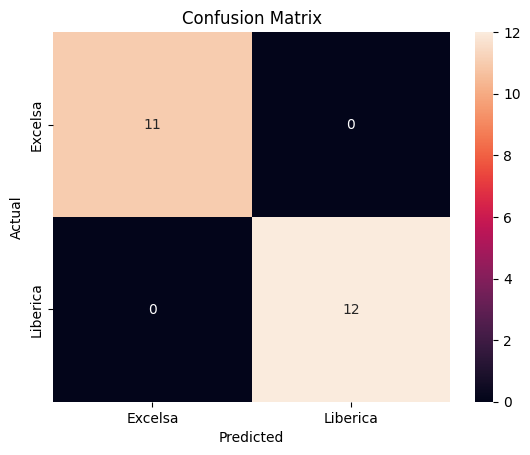

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['Excelsa', 'Liberica']))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', xticklabels=['Excelsa', 'Liberica'], yticklabels=['Excelsa', 'Liberica'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Saving Screenshot 2025-07-31 191744.png to Screenshot 2025-07-31 191744 (5).png


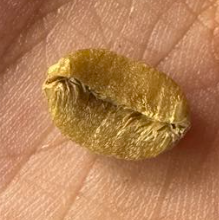

In [ ]:
from google.colab import files
from IPython.display import Image as IPImage, display

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
display(IPImage(filename=img_path))

def predict_segments(img_path):
    _, features = preprocess_and_extract(img_path)
    if features is None:
        print("Feature extraction failed.")
        return

    shape_input = scaler.transform([features])
    proba = rf_model.predict_proba(shape_input)[0]
    classes = ['Excelsa', 'Liberica']

    area, w, h, aspect_ratio, circularity, eccentricity, tip_sharpness, s_curve, r, g, b = features[:11]

    print(f"Area: {area:.1f}, Width: {w}, Height: {h}")
    print(f"Aspect Ratio: {aspect_ratio:.2f}, Circularity: {circularity:.2f}, Eccentricity: {eccentricity:.2f}")
    print(f"Tip Sharpness: {tip_sharpness:.2f}")
    print(f"S-Curve Strength: {s_curve:.5f}")
    print(f"Mean Color: R={r:.1f}, G={g:.1f}, B={b:.1f}")


    # Decision Trial 1

    # if s_curve >= 0.4:
    #     decision = "Liberica (prominent S-curve)"
    # elif s_curve < 0.2 and eccentricity < 0.6:
    #     decision = "Excelsa (straight/slight S-curve and round)"
    # elif eccentricity >= 0.75 and aspect_ratio > 1.1:
    #     decision = "Liberica (elongated shape fallback)"
    # elif circularity >= 0.7 and eccentricity < 0.6:
    #     decision = "Excelsa (round shape fallback)"
    # else:
    #     pred = np.argmax(proba)
    #     decision = f"{classes[pred]} (by model, fallback)"

    # Decison Trial 2
    # if s_curve >= 0.6:
    #     decision = "Liberica (prominent S-curve)"
    # elif s_curve < 0.2:
    #     decision = "Excelsa (straight/slight S-curve)"
    # elif 0.4 <= s_curve <= 0.6:
    #     if eccentricity >= 0.6 and circularity < 0.3 and tip_sharpness < 100:
    #         decision = "Liberica (elongated + blunt tip + low circularity)"
    #     elif eccentricity < 0.5 and circularity > 0.5 and tip_sharpness > 110:
    #         decision = "Excelsa (round + sharp tip)"
    #     else:
    #         pred = np.argmax(proba)
    #         decision = f"{classes[pred]} (by model fallback)"
    # else:
    #     pred = np.argmax(proba)
    #     decision = f"{classes[pred]} (by model fallback)"

    rounded_curve = round(s_curve, 5)

    if s_curve >= 0.49:
        decision = "Liberica (prominent S-curve)"
    elif s_curve < 0.2:
        if eccentricity >= 0.75 and aspect_ratio >= 1.1:
            decision = "Liberica (elongated shape fallback)"
        elif circularity >= 0.5 and tip_sharpness >= 105:
            decision = "Excelsa (round + sharp tip fallback)"
        else:
            pred = np.argmax(proba)
            decision = f"{classes[pred]} (model fallback)"
    elif 0.2 <= s_curve < 0.6:
        if eccentricity >= 0.75 and aspect_ratio >= 1.1:
            decision = "Liberica (shape confirms ambiguous S-curve)"
        elif circularity >= 0.5 and tip_sharpness >= 105:
            decision = "Excelsa (shape confirms ambiguous S-curve)"
        else:
            pred = np.argmax(proba)
            decision = f"{classes[pred]} (model fallback)"
    else:
        pred = np.argmax(proba)
        decision = f"{classes[pred]} (model fallback)"


    print(f"\nFinal Decision: {decision}")


In [ ]:
predict_segments(img_path)

Area: 17661.5, Width: 174, Height: 153
Aspect Ratio: 1.14, Circularity: 0.34, Eccentricity: 0.83
Tip Sharpness: 98.35
S-Curve Strength: 0.00547
Mean Color: R=47.0, G=97.1, B=143.7

Final Decision: Liberica (elongated shape fallback)


In [ ]:
import pickle
from google.colab import files

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

files.download('rf_model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>